#### Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import ReLU
from torch.nn import LeakyReLU
from torch.nn import Sigmoid
from torch.nn import Tanh
from torch.nn import ELU
from torch.nn import Conv2d
from torch.nn import AvgPool2d
from torch.nn import MaxPool2d
from torch import flatten
import time

#### Load dataset and create train/test set

In [42]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


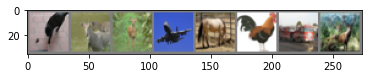

  cat  deer  deer plane horse  bird truck  deer


In [43]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

#### Choose a Device

In [33]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [44]:
def train_test(net):

    # We use cross-entropy as loss function.
    loss_func = nn.CrossEntropyLoss()

    # SGD/Adamax optimizer
#     opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    opt = optim.Adamax(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

    # Training procedure
    st = time.time()
    avg_losses = []   # Avg. losses.
    epochs = 20       # Total epochs.
    print_freq = 5000  # Print frequency.

    for epoch in range(epochs):  # Loop over the dataset multiple times.
        running_loss = 0.0       # Initialize running loss.
        for i, data in enumerate(trainloader, 0):
            # Get the inputs.
            inputs, labels = data
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            opt.zero_grad()

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)

            # Backward step.
            loss.backward()

            # Optimization step (update the parameters).
            opt.step()

            # Print statistics.
            running_loss += loss.item()
            if i % print_freq == print_freq - 1: # Print every several mini-batches.
                avg_loss = running_loss / print_freq
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                    epoch, i, avg_loss))
                avg_losses.append(avg_loss)
                running_loss = 0.0

    print('Finished Training.')
    et = time.time()
    print('Training time:', (et-st)/60, 'min')

    plt.plot(avg_losses)
    plt.xlabel('mini-batch index / {}'.format(print_freq))
    plt.ylabel('avg. mini-batch loss')
    plt.title('Training loss curve')
    plt.show()


    # Check several images.
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))


    # Get test accuracy.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('\n\nAccuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


    # Get test accuracy for each class.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

## Baseline CNN

In [85]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
        
        self.lin1 = nn.Linear(20*8*8, 100)
        self.lin2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin1): Linear(in_features=1280, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=10, bias=True)
)

[epoch: 0, i:  4999] avg mini-batch loss: 1.868
[epoch: 0, i:  9999] avg mini-batch loss: 1.548
[epoch: 1, i:  4999] avg mini-batch loss: 1.375
[epoch: 1, i:  9999] avg mini-batch loss: 1.289
[epoch: 2, i:  4999] avg mini-batch loss: 1.167
[epoch: 2, i:  9999] avg mini-batch loss: 1.141
[epoch: 3, i:  4999] avg mini-batch loss: 1.044
[epoch: 3, i:  9999] avg mini-batch loss: 1.043
[epoch: 4, i:  4999] avg mini-batch loss: 0.949
[epoch: 4, i:  9999] avg mini-batch loss: 0.964
[epoch: 5, i:  4999] avg mini-batch loss: 0.856
[epoch: 5, i:  9999] avg mini-batch loss: 0.884
[epoch: 6, i:  4999] avg mini-batch loss: 0.780
[epoch: 6, i:  9999] avg mini-batch loss: 0.816
[epoch: 7, i:  4999] avg mini-batch loss: 0.707
[epoch: 7, i:  9999] avg mini-batch loss: 0.757
[epoch: 8, i:  4999] avg mini-batch loss: 0.655
[epoch: 8, i:  9999] avg mini-batch loss: 0.691
[epoch: 9, i:  4999] avg mini-batch loss: 0.597
[epoch: 9, i:  9999] avg mini-batch loss: 0.634
Finished Training.
Training time: 7.1882

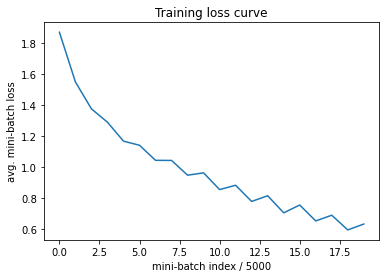

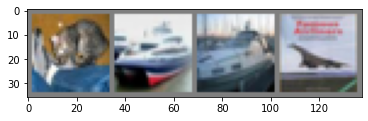

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane


Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 62 %
Accuracy of   car : 82 %
Accuracy of  bird : 58 %
Accuracy of   cat : 51 %
Accuracy of  deer : 66 %
Accuracy of   dog : 55 %
Accuracy of  frog : 66 %
Accuracy of horse : 75 %
Accuracy of  ship : 71 %
Accuracy of truck : 65 %


In [87]:
train_test(net)

## Improved CNN

#### changing the number of channels produced by the convolutional layers
1st convolutional layer: out_channels=40 <br>
2nd convolutional layer: out_channels=80

In [92]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=40, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3, padding=1)
        
        self.lin1 = nn.Linear(80*8*8, 100)
        self.lin2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin1): Linear(in_features=5120, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=10, bias=True)
)

[epoch: 0, i:  4999] avg mini-batch loss: 1.797
[epoch: 0, i:  9999] avg mini-batch loss: 1.462
[epoch: 1, i:  4999] avg mini-batch loss: 1.242
[epoch: 1, i:  9999] avg mini-batch loss: 1.158
[epoch: 2, i:  4999] avg mini-batch loss: 1.012
[epoch: 2, i:  9999] avg mini-batch loss: 0.994
[epoch: 3, i:  4999] avg mini-batch loss: 0.863
[epoch: 3, i:  9999] avg mini-batch loss: 0.855
[epoch: 4, i:  4999] avg mini-batch loss: 0.745
[epoch: 4, i:  9999] avg mini-batch loss: 0.740
[epoch: 5, i:  4999] avg mini-batch loss: 0.631
[epoch: 5, i:  9999] avg mini-batch loss: 0.666
[epoch: 6, i:  4999] avg mini-batch loss: 0.532
[epoch: 6, i:  9999] avg mini-batch loss: 0.559
[epoch: 7, i:  4999] avg mini-batch loss: 0.440
[epoch: 7, i:  9999] avg mini-batch loss: 0.471
[epoch: 8, i:  4999] avg mini-batch loss: 0.346
[epoch: 8, i:  9999] avg mini-batch loss: 0.394
[epoch: 9, i:  4999] avg mini-batch loss: 0.270
[epoch: 9, i:  9999] avg mini-batch loss: 0.320
Finished Training.
Training time: 7.8517

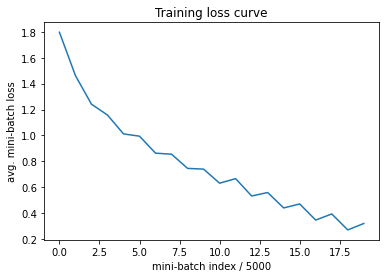

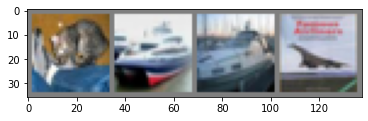

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


Accuracy of the network on the 10000 test images: 71 %
Accuracy of plane : 78 %
Accuracy of   car : 82 %
Accuracy of  bird : 63 %
Accuracy of   cat : 54 %
Accuracy of  deer : 65 %
Accuracy of   dog : 60 %
Accuracy of  frog : 73 %
Accuracy of horse : 74 %
Accuracy of  ship : 81 %
Accuracy of truck : 77 %


In [93]:
train_test(net)

#### train CNN with batch norm in each of 3 convolutional blocks

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=40, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(40)
        self.conv2 = nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(80)
        self.conv3 = nn.Conv2d(in_channels=80, out_channels=160, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(160)
        
        self.lin1 = nn.Linear(160*4*4, 100)
        self.lin2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

net = Net() # Create the network instance.
net.to(device)

Net(
  (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=2560, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=10, bias=True)
)

[epoch: 0, i:  4999] avg mini-batch loss: 1.562
[epoch: 0, i:  9999] avg mini-batch loss: 1.227
[epoch: 1, i:  4999] avg mini-batch loss: 0.999
[epoch: 1, i:  9999] avg mini-batch loss: 0.919
[epoch: 2, i:  4999] avg mini-batch loss: 0.784
[epoch: 2, i:  9999] avg mini-batch loss: 0.773
[epoch: 3, i:  4999] avg mini-batch loss: 0.669
[epoch: 3, i:  9999] avg mini-batch loss: 0.667
[epoch: 4, i:  4999] avg mini-batch loss: 0.575
[epoch: 4, i:  9999] avg mini-batch loss: 0.573
[epoch: 5, i:  4999] avg mini-batch loss: 0.502
[epoch: 5, i:  9999] avg mini-batch loss: 0.514
[epoch: 7, i:  9999] avg mini-batch loss: 0.401
[epoch: 8, i:  4999] avg mini-batch loss: 0.320
[epoch: 8, i:  9999] avg mini-batch loss: 0.358
[epoch: 9, i:  4999] avg mini-batch loss: 0.276
[epoch: 9, i:  9999] avg mini-batch loss: 0.303
Finished Training.
Training time: 10.595346343517303 min


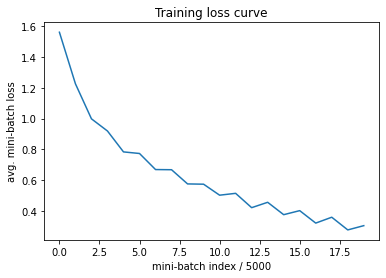

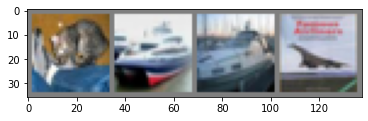

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car  ship plane


Accuracy of the network on the 10000 test images: 78 %
Accuracy of plane : 78 %
Accuracy of   car : 90 %
Accuracy of  bird : 65 %
Accuracy of   cat : 63 %
Accuracy of  deer : 77 %
Accuracy of   dog : 72 %
Accuracy of  frog : 83 %
Accuracy of horse : 81 %
Accuracy of  ship : 88 %
Accuracy of truck : 84 %


In [18]:
train_test(net)

### Try different activation function

ReLU()
[epoch: 0, i:  4999] avg mini-batch loss: 1.888
[epoch: 0, i:  9999] avg mini-batch loss: 1.540
[epoch: 1, i:  4999] avg mini-batch loss: 1.356
[epoch: 1, i:  9999] avg mini-batch loss: 1.298
[epoch: 2, i:  4999] avg mini-batch loss: 1.154
[epoch: 2, i:  9999] avg mini-batch loss: 1.147
[epoch: 3, i:  4999] avg mini-batch loss: 1.034
[epoch: 3, i:  9999] avg mini-batch loss: 1.022
[epoch: 4, i:  4999] avg mini-batch loss: 0.931
[epoch: 4, i:  9999] avg mini-batch loss: 0.934
[epoch: 5, i:  4999] avg mini-batch loss: 0.856
[epoch: 5, i:  9999] avg mini-batch loss: 0.861
[epoch: 6, i:  4999] avg mini-batch loss: 0.772
[epoch: 6, i:  9999] avg mini-batch loss: 0.803
[epoch: 7, i:  4999] avg mini-batch loss: 0.697
[epoch: 7, i:  9999] avg mini-batch loss: 0.752
[epoch: 8, i:  4999] avg mini-batch loss: 0.654
[epoch: 8, i:  9999] avg mini-batch loss: 0.682
[epoch: 9, i:  4999] avg mini-batch loss: 0.586
[epoch: 9, i:  9999] avg mini-batch loss: 0.653
Finished Training.
7.709306486447

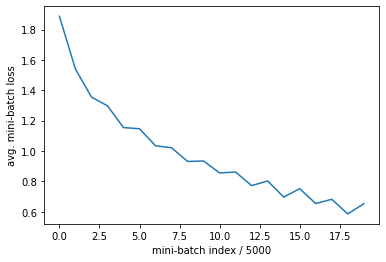

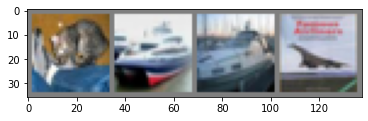

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car  ship  ship
Accuracy of the network on the 10000 test images: 64 %
Accuracy of plane : 71 %
Accuracy of   car : 74 %
Accuracy of  bird : 47 %
Accuracy of   cat : 48 %
Accuracy of  deer : 67 %
Accuracy of   dog : 47 %
Accuracy of  frog : 74 %
Accuracy of horse : 61 %
Accuracy of  ship : 80 %
Accuracy of truck : 74 %
LeakyReLU(negative_slope=0.01)
[epoch: 0, i:  4999] avg mini-batch loss: 1.888
[epoch: 0, i:  9999] avg mini-batch loss: 1.537
[epoch: 1, i:  4999] avg mini-batch loss: 1.365
[epoch: 1, i:  9999] avg mini-batch loss: 1.306
[epoch: 2, i:  4999] avg mini-batch loss: 1.188
[epoch: 2, i:  9999] avg mini-batch loss: 1.142
[epoch: 3, i:  4999] avg mini-batch loss: 1.056
[epoch: 3, i:  9999] avg mini-batch loss: 1.041
[epoch: 4, i:  4999] avg mini-batch loss: 0.949
[epoch: 4, i:  9999] avg mini-batch loss: 0.955
[epoch: 7, i:  9999] avg mini-batch loss: 0.741
[epoch: 8, i:  4999] avg mini-batch loss: 0.644
[epoch: 8, i: 

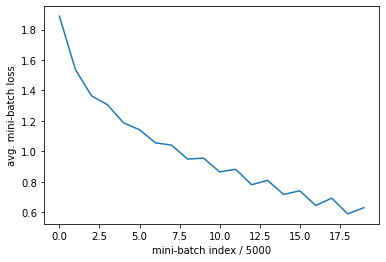

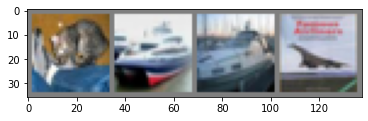

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship
Accuracy of the network on the 10000 test images: 64 %
Accuracy of plane : 68 %
Accuracy of   car : 67 %
Accuracy of  bird : 50 %
Accuracy of   cat : 55 %
Accuracy of  deer : 66 %
Accuracy of   dog : 44 %
Accuracy of  frog : 71 %
Accuracy of horse : 63 %
Accuracy of  ship : 77 %
Accuracy of truck : 75 %
Sigmoid()
[epoch: 0, i:  4999] avg mini-batch loss: 2.311
[epoch: 0, i:  9999] avg mini-batch loss: 2.305
[epoch: 1, i:  4999] avg mini-batch loss: 2.296
[epoch: 1, i:  9999] avg mini-batch loss: 2.144
[epoch: 2, i:  4999] avg mini-batch loss: 1.999
[epoch: 2, i:  9999] avg mini-batch loss: 1.951
[epoch: 3, i:  4999] avg mini-batch loss: 1.880
[epoch: 3, i:  9999] avg mini-batch loss: 1.821
[epoch: 4, i:  4999] avg mini-batch loss: 1.755
[epoch: 4, i:  9999] avg mini-batch loss: 1.724
[epoch: 5, i:  4999] avg mini-batch loss: 1.673
[epoch: 5, i:  9999] avg mini-batch loss: 1.667
[epoch: 6, i:  4999] avg mini-batch

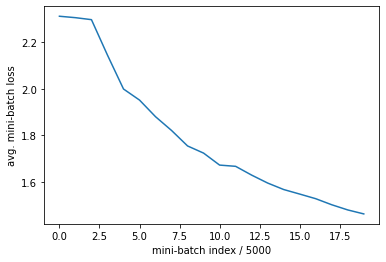

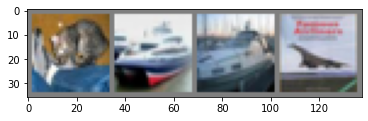

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car  ship
Accuracy of the network on the 10000 test images: 48 %
Accuracy of plane : 59 %
Accuracy of   car : 58 %
Accuracy of  bird : 41 %
Accuracy of   cat : 23 %
Accuracy of  deer : 42 %
Accuracy of   dog : 32 %
Accuracy of  frog : 56 %
Accuracy of horse : 51 %
Accuracy of  ship : 67 %
Accuracy of truck : 52 %
Tanh()
[epoch: 0, i:  4999] avg mini-batch loss: 1.841
[epoch: 0, i:  9999] avg mini-batch loss: 1.642
[epoch: 1, i:  4999] avg mini-batch loss: 1.485
[epoch: 1, i:  9999] avg mini-batch loss: 1.425
[epoch: 2, i:  4999] avg mini-batch loss: 1.337
[epoch: 2, i:  9999] avg mini-batch loss: 1.305
[epoch: 3, i:  4999] avg mini-batch loss: 1.230
[epoch: 3, i:  9999] avg mini-batch loss: 1.209
[epoch: 4, i:  4999] avg mini-batch loss: 1.140
[epoch: 4, i:  9999] avg mini-batch loss: 1.149
[epoch: 5, i:  4999] avg mini-batch loss: 1.066
[epoch: 5, i:  9999] avg mini-batch loss: 1.095
[epoch: 6, i:  4999] avg mini-batch lo

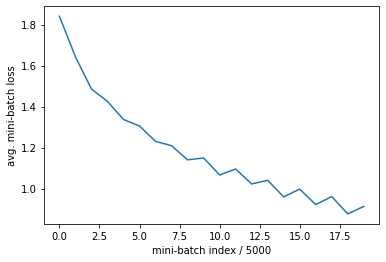

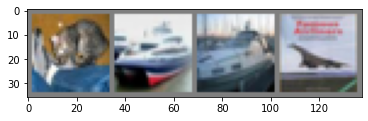

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane
Accuracy of the network on the 10000 test images: 59 %
Accuracy of plane : 70 %
Accuracy of   car : 77 %
Accuracy of  bird : 43 %
Accuracy of   cat : 42 %
Accuracy of  deer : 47 %
Accuracy of   dog : 50 %
Accuracy of  frog : 68 %
Accuracy of horse : 70 %
Accuracy of  ship : 64 %
Accuracy of truck : 61 %
ELU(alpha=1.0)
[epoch: 0, i:  4999] avg mini-batch loss: 1.825
[epoch: 0, i:  9999] avg mini-batch loss: 1.561
[epoch: 1, i:  4999] avg mini-batch loss: 1.340
[epoch: 1, i:  9999] avg mini-batch loss: 1.301
[epoch: 2, i:  4999] avg mini-batch loss: 1.209
[epoch: 2, i:  9999] avg mini-batch loss: 1.184
[epoch: 3, i:  4999] avg mini-batch loss: 1.090
[epoch: 3, i:  9999] avg mini-batch loss: 1.107
[epoch: 4, i:  4999] avg mini-batch loss: 1.018
[epoch: 4, i:  9999] avg mini-batch loss: 1.028
[epoch: 5, i:  4999] avg mini-batch loss: 0.933
[epoch: 5, i:  9999] avg mini-batch loss: 0.950
[epoch: 6, i:  4999] avg mini-

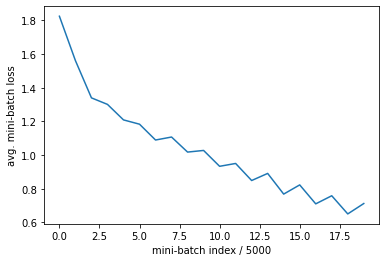

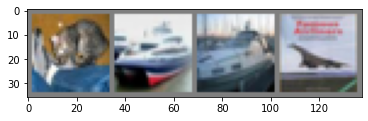

GroundTruth:    cat  ship  ship plane
Predicted:    dog   car  ship  ship
Accuracy of the network on the 10000 test images: 62 %
Accuracy of plane : 54 %
Accuracy of   car : 68 %
Accuracy of  bird : 49 %
Accuracy of   cat : 51 %
Accuracy of  deer : 62 %
Accuracy of   dog : 52 %
Accuracy of  frog : 58 %
Accuracy of horse : 74 %
Accuracy of  ship : 73 %
Accuracy of truck : 74 %


In [10]:
f_list = [ReLU(), LeakyReLU(), Sigmoid(), Tanh(), ELU()]

for f in f_list: 
    print(f)
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()

            #block one
            self.c_1 = Conv2d(3, 10, 3, stride=1, padding=1)
            self.r_1 = f
            self.avg_1 = AvgPool2d(2)

            #block two
            self.c_2 = Conv2d(10, 20, 3, stride=1, padding=1)
            self.r_2 = f
            self.avg_2 = AvgPool2d(2)

            self.l_1 = nn.Linear(1280, 100)
            self.r_3 = f
            self.l_2 = nn.Linear(100, 10)

        def forward(self, x):

            x = self.c_1(x)
            x = self.r_1(x)
            x = self.avg_1(x)

            x = self.c_2(x)
            x = self.r_2(x)
            x = self.avg_2(x)

            x = flatten(x, start_dim=1)

            x = self.l_1(x)
            x = self.r_3(x)
            x = self.l_2(x)

            return x

    net = Net()     # Create the network instance.
    net.to(device)  # Move the network parameters to the specified device.

    # We use cross-entropy as loss function.
    loss_func = nn.CrossEntropyLoss()

    # SGD
    opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


    # Training procedure
    st = time.time()
    avg_losses = []   # Avg. losses.
    epochs = 10       # Total epochs.
    print_freq = 5000  # Print frequency.

    for epoch in range(epochs):  # Loop over the dataset multiple times.
        running_loss = 0.0       # Initialize running loss.
        for i, data in enumerate(trainloader, 0):
            # Get the inputs.
            inputs, labels = data
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            opt.zero_grad()

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)

            # Backward step.
            loss.backward()

            # Optimization step (update the parameters).
            opt.step()

            # Print statistics.
            running_loss += loss.item()
            if i % print_freq == print_freq - 1: # Print every several mini-batches.
                avg_loss = running_loss / print_freq
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                    epoch, i, avg_loss))
                avg_losses.append(avg_loss)
                running_loss = 0.0

    print('Finished Training.')
    et = time.time()
    print((et-st)/60)

    plt.plot(avg_losses)
    plt.xlabel('mini-batch index / {}'.format(print_freq))
    plt.ylabel('avg. mini-batch loss')
    plt.show()


    # Check several images.
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))


    # Get test accuracy.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


    # Get test accuracy for each class.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

### Try different optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
[epoch: 0, i:  4999] avg mini-batch loss: 1.860
[epoch: 0, i:  9999] avg mini-batch loss: 1.545
[epoch: 1, i:  4999] avg mini-batch loss: 1.350
[epoch: 1, i:  9999] avg mini-batch loss: 1.278
[epoch: 2, i:  4999] avg mini-batch loss: 1.175
[epoch: 2, i:  9999] avg mini-batch loss: 1.133
[epoch: 3, i:  4999] avg mini-batch loss: 1.051
[epoch: 3, i:  9999] avg mini-batch loss: 1.045
[epoch: 4, i:  4999] avg mini-batch loss: 0.948
[epoch: 4, i:  9999] avg mini-batch loss: 0.965
[epoch: 5, i:  4999] avg mini-batch loss: 0.866
[epoch: 5, i:  9999] avg mini-batch loss: 0.878
[epoch: 6, i:  4999] avg mini-batch loss: 0.780
[epoch: 6, i:  9999] avg mini-batch loss: 0.806
[epoch: 7, i:  4999] avg mini-batch loss: 0.718
[epoch: 7, i:  9999] avg mini-batch loss: 0.744
[epoch: 8, i:  4999] avg mini-batch loss: 0.651
[epoc

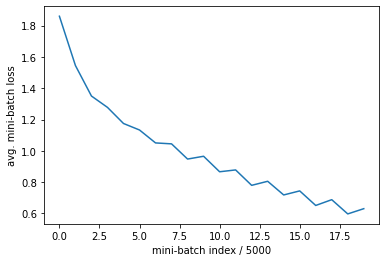

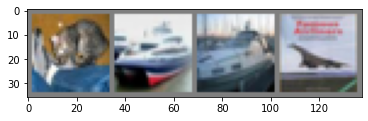

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 64 %
Accuracy of   car : 75 %
Accuracy of  bird : 48 %
Accuracy of   cat : 42 %
Accuracy of  deer : 66 %
Accuracy of   dog : 49 %
Accuracy of  frog : 73 %
Accuracy of horse : 74 %
Accuracy of  ship : 83 %
Accuracy of truck : 71 %
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)
[epoch: 0, i:  4999] avg mini-batch loss: 0.843
[epoch: 0, i:  9999] avg mini-batch loss: 0.892
[epoch: 1, i:  4999] avg mini-batch loss: 0.711
[epoch: 1, i:  9999] avg mini-batch loss: 0.769
[epoch: 2, i:  4999] avg mini-batch loss: 0.588
[epoch: 2, i:  9999] avg mini-batch loss: 0.642
[epoch: 3, i:  4999] avg mini-batch loss: 0.496
[epoch: 3, i:  9999] avg mini-batch loss: 0.556
[epoch: 4, i:  

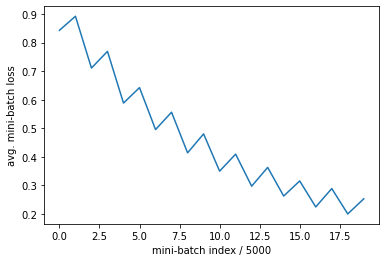

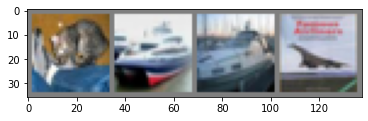

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane
Accuracy of the network on the 10000 test images: 64 %
Accuracy of plane : 76 %
Accuracy of   car : 78 %
Accuracy of  bird : 55 %
Accuracy of   cat : 46 %
Accuracy of  deer : 53 %
Accuracy of   dog : 54 %
Accuracy of  frog : 72 %
Accuracy of horse : 66 %
Accuracy of  ship : 73 %
Accuracy of truck : 74 %
Adagrad (
Parameter Group 0
    eps: 1e-10
    foreach: None
    initial_accumulator_value: 0
    lr: 0.01
    lr_decay: 0
    maximize: False
    weight_decay: 0
)
[epoch: 0, i:  4999] avg mini-batch loss: 0.108
[epoch: 0, i:  9999] avg mini-batch loss: 0.079
[epoch: 1, i:  4999] avg mini-batch loss: 0.041
[epoch: 1, i:  9999] avg mini-batch loss: 0.044
[epoch: 2, i:  4999] avg mini-batch loss: 0.033
[epoch: 2, i:  9999] avg mini-batch loss: 0.031
[epoch: 3, i:  4999] avg mini-batch loss: 0.027
[epoch: 3, i:  9999] avg mini-batch loss: 0.026
[epoch: 4, i:  4999] avg mini-batch loss: 0.022
[epoch: 4, i:  9999] avg

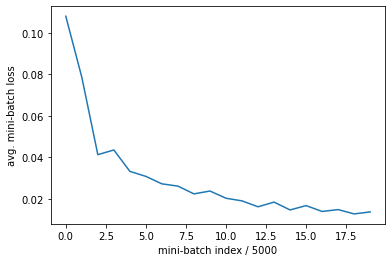

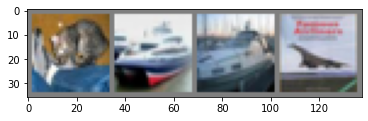

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 66 %
Accuracy of plane : 73 %
Accuracy of   car : 79 %
Accuracy of  bird : 53 %
Accuracy of   cat : 47 %
Accuracy of  deer : 58 %
Accuracy of   dog : 55 %
Accuracy of  frog : 72 %
Accuracy of horse : 72 %
Accuracy of  ship : 78 %
Accuracy of truck : 73 %
Adadelta (
Parameter Group 0
    eps: 1e-06
    foreach: None
    lr: 1.0
    maximize: False
    rho: 0.9
    weight_decay: 0
)
[epoch: 0, i:  4999] avg mini-batch loss: 0.081
[epoch: 0, i:  9999] avg mini-batch loss: 0.114
[epoch: 1, i:  4999] avg mini-batch loss: 0.088
[epoch: 1, i:  9999] avg mini-batch loss: 0.106
[epoch: 2, i:  4999] avg mini-batch loss: 0.082
[epoch: 2, i:  9999] avg mini-batch loss: 0.101
[epoch: 3, i:  4999] avg mini-batch loss: 0.083
[epoch: 3, i:  9999] avg mini-batch loss: 0.102
[epoch: 4, i:  4999] avg mini-batch loss: 0.088
[epoch: 4, i:  9999] avg mini-batch loss: 0.102
[epoch: 5, i

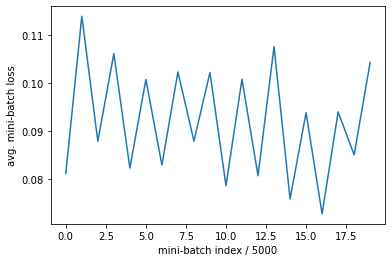

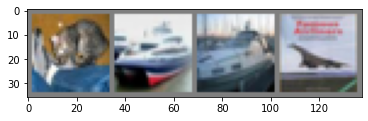

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane
Accuracy of the network on the 10000 test images: 64 %
Accuracy of plane : 69 %
Accuracy of   car : 80 %
Accuracy of  bird : 50 %
Accuracy of   cat : 40 %
Accuracy of  deer : 62 %
Accuracy of   dog : 55 %
Accuracy of  frog : 68 %
Accuracy of horse : 74 %
Accuracy of  ship : 77 %
Accuracy of truck : 70 %
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)
[epoch: 0, i:  4999] avg mini-batch loss: 0.209
[epoch: 0, i:  9999] avg mini-batch loss: 0.244
[epoch: 1, i:  4999] avg mini-batch loss: 0.194
[epoch: 1, i:  9999] avg mini-batch loss: 0.231
[epoch: 2, i:  4999] avg mini-batch loss: 0.179
[epoch: 2, i:  9999] avg mini-batch loss: 0.235
[epoch: 3, i:  4999] avg mini-batch loss: 0.189
[epoch: 3, i:  9999] avg mini-batch loss: 0.257
[epoch: 4, i:  4999] avg mini-batch loss: 0.199
[epoch

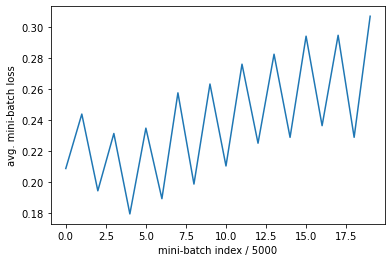

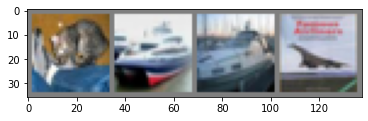

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship  ship
Accuracy of the network on the 10000 test images: 63 %
Accuracy of plane : 60 %
Accuracy of   car : 70 %
Accuracy of  bird : 53 %
Accuracy of   cat : 49 %
Accuracy of  deer : 50 %
Accuracy of   dog : 60 %
Accuracy of  frog : 73 %
Accuracy of horse : 68 %
Accuracy of  ship : 80 %
Accuracy of truck : 68 %
Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    foreach: None
    lr: 0.002
    maximize: False
    weight_decay: 0
)
[epoch: 0, i:  4999] avg mini-batch loss: 0.127
[epoch: 0, i:  9999] avg mini-batch loss: 0.104
[epoch: 1, i:  4999] avg mini-batch loss: 0.058
[epoch: 1, i:  9999] avg mini-batch loss: 0.055
[epoch: 2, i:  4999] avg mini-batch loss: 0.033
[epoch: 2, i:  9999] avg mini-batch loss: 0.036
[epoch: 3, i:  4999] avg mini-batch loss: 0.022
[epoch: 3, i:  9999] avg mini-batch loss: 0.022
[epoch: 4, i:  4999] avg mini-batch loss: 0.014
[epoch: 4, i:  9999] avg mini-batch loss: 0.015
[

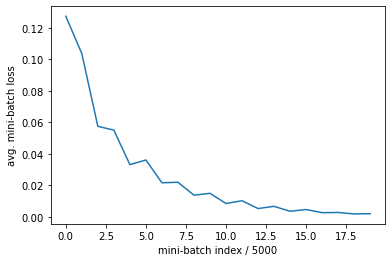

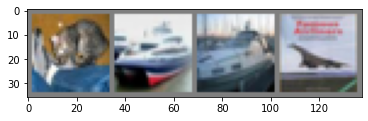

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car  ship
Accuracy of the network on the 10000 test images: 66 %
Accuracy of plane : 74 %
Accuracy of   car : 80 %
Accuracy of  bird : 51 %
Accuracy of   cat : 49 %
Accuracy of  deer : 60 %
Accuracy of   dog : 53 %
Accuracy of  frog : 75 %
Accuracy of horse : 73 %
Accuracy of  ship : 78 %
Accuracy of truck : 72 %
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)
[epoch: 0, i:  4999] avg mini-batch loss: 2.096
[epoch: 0, i:  9999] avg mini-batch loss: 1.822
[epoch: 1, i:  4999] avg mini-batch loss: 1.772
[epoch: 1, i:  9999] avg mini-batch loss: 1.774
[epoch: 2, i:  4999] avg mini-batch loss: 1.808
[epoch: 2, i:  9999] avg mini-batch loss: 1.793
[epoch: 3, i:  4999] avg mini-batch loss: 1.807
[epoch: 3, i:  9999] avg mini-batch loss: 1.865
[epoch: 4, i:  4999] avg mini-batch loss: 1

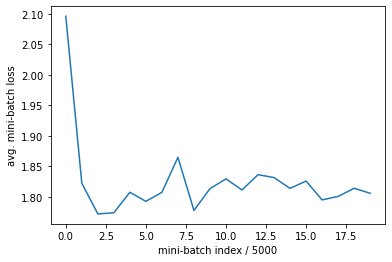

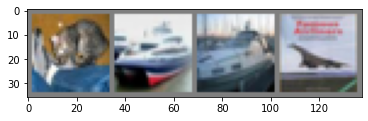

GroundTruth:    cat  ship  ship plane
Predicted:    cat truck  ship  ship
Accuracy of the network on the 10000 test images: 35 %
Accuracy of plane : 33 %
Accuracy of   car : 46 %
Accuracy of  bird : 33 %
Accuracy of   cat : 22 %
Accuracy of  deer : 10 %
Accuracy of   dog : 38 %
Accuracy of  frog : 39 %
Accuracy of horse : 42 %
Accuracy of  ship : 36 %
Accuracy of truck : 51 %


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #block one
        self.c_1 = Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = ReLU()
        self.avg_1 = AvgPool2d(2)

        #block two
        self.c_2 = Conv2d(10, 20, 3, stride=1, padding=1)
        self.r_2 = ReLU()
        self.avg_2 = AvgPool2d(2)

        self.l_1 = nn.Linear(1280, 100)
        self.r_3 = ReLU()
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):

        x = self.c_1(x)
        x = self.r_1(x)
        x = self.avg_1(x)

        x = self.c_2(x)
        x = self.r_2(x)
        x = self.avg_2(x)

        x = flatten(x, start_dim=1)

        x = self.l_1(x)
        x = self.r_3(x)
        x = self.l_2(x)


        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

# train with different optimizers
opt_list = [optim.SGD(net.parameters(), lr=0.001, momentum=0.9), 
            optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False), 
            optim.Adagrad(net.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10), 
            optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0), 
            optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False),
            optim.Adamax(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0),
            optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)]

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

for opt in opt_list:
    # SGD
    opt = opt
    print(opt)
    # Training procedure
    st = time.time()
    avg_losses = []   # Avg. losses.
    epochs = 10       # Total epochs.
    print_freq = 5000  # Print frequency.

    for epoch in range(epochs):  # Loop over the dataset multiple times.
        running_loss = 0.0       # Initialize running loss.
        for i, data in enumerate(trainloader, 0):
            # Get the inputs.
            inputs, labels = data
            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            opt.zero_grad()

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)

            # Backward step.
            loss.backward()

            # Optimization step (update the parameters).
            opt.step()

            # Print statistics.
            running_loss += loss.item()
            if i % print_freq == print_freq - 1: # Print every several mini-batches.
                avg_loss = running_loss / print_freq
                print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                    epoch, i, avg_loss))
                avg_losses.append(avg_loss)
                running_loss = 0.0

    print('Finished Training.')
    et = time.time()
    print((et-st)/60)

    plt.plot(avg_losses)
    plt.xlabel('mini-batch index / {}'.format(print_freq))
    plt.ylabel('avg. mini-batch loss')
    plt.show()


    # Check several images.
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))


    # Get test accuracy.
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


    # Get test accuracy for each class.
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

### Try different pooling

[epoch: 0, i:  4999] avg mini-batch loss: 1.772
[epoch: 0, i:  9999] avg mini-batch loss: 1.363
[epoch: 1, i:  4999] avg mini-batch loss: 1.138
[epoch: 1, i:  9999] avg mini-batch loss: 1.088
[epoch: 2, i:  4999] avg mini-batch loss: 0.961
[epoch: 2, i:  9999] avg mini-batch loss: 0.959
[epoch: 3, i:  4999] avg mini-batch loss: 0.855
[epoch: 3, i:  9999] avg mini-batch loss: 0.849
[epoch: 4, i:  4999] avg mini-batch loss: 0.741
[epoch: 4, i:  9999] avg mini-batch loss: 0.775
[epoch: 5, i:  4999] avg mini-batch loss: 0.662
[epoch: 5, i:  9999] avg mini-batch loss: 0.704
[epoch: 6, i:  4999] avg mini-batch loss: 0.579
[epoch: 6, i:  9999] avg mini-batch loss: 0.640
[epoch: 7, i:  4999] avg mini-batch loss: 0.522
[epoch: 7, i:  9999] avg mini-batch loss: 0.581
[epoch: 8, i:  4999] avg mini-batch loss: 0.473
[epoch: 8, i:  9999] avg mini-batch loss: 0.538
[epoch: 9, i:  4999] avg mini-batch loss: 0.423
[epoch: 9, i:  9999] avg mini-batch loss: 0.478
Finished Training.
7.913433015346527


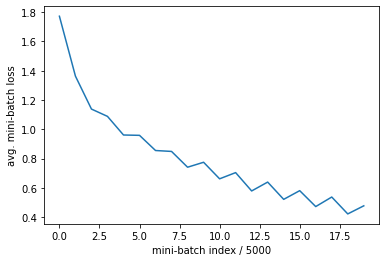

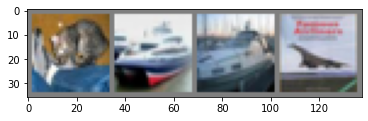

GroundTruth:    cat  ship  ship plane
Predicted:    dog   car  ship   car
Accuracy of the network on the 10000 test images: 65 %
Accuracy of plane : 65 %
Accuracy of   car : 79 %
Accuracy of  bird : 55 %
Accuracy of   cat : 47 %
Accuracy of  deer : 61 %
Accuracy of   dog : 63 %
Accuracy of  frog : 73 %
Accuracy of horse : 66 %
Accuracy of  ship : 78 %
Accuracy of truck : 67 %


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #block one
        self.c_1 = Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = ReLU()
        self.max_1 = MaxPool2d(2)

        #block two
        self.c_2 = Conv2d(10, 20, 3, stride=1, padding=1)
        self.r_2 = ReLU()
        self.max_2 = MaxPool2d(2)

        self.l_1 = nn.Linear(1280, 100)
        self.r_3 = ReLU()
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):

        x = self.c_1(x)
        x = self.r_1(x)
        x = self.max_1(x)

        x = self.c_2(x)
        x = self.r_2(x)
        x = self.max_2(x)

        x = flatten(x, start_dim=1)

        x = self.l_1(x)
        x = self.r_3(x)
        x = self.l_2(x)

        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

# SGD
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 


# Training procedure
st = time.time()
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 5000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')
et = time.time()
print((et-st)/60)

plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()


# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

### Add more layers

[epoch: 0, i:  4999] avg mini-batch loss: 1.809
[epoch: 0, i:  9999] avg mini-batch loss: 1.518
[epoch: 1, i:  4999] avg mini-batch loss: 1.328
[epoch: 1, i:  9999] avg mini-batch loss: 1.238
[epoch: 2, i:  4999] avg mini-batch loss: 1.125
[epoch: 2, i:  9999] avg mini-batch loss: 1.069
[epoch: 3, i:  4999] avg mini-batch loss: 0.992
[epoch: 3, i:  9999] avg mini-batch loss: 0.957
[epoch: 4, i:  4999] avg mini-batch loss: 0.896
[epoch: 4, i:  9999] avg mini-batch loss: 0.879
[epoch: 5, i:  4999] avg mini-batch loss: 0.831
[epoch: 5, i:  9999] avg mini-batch loss: 0.818
[epoch: 6, i:  4999] avg mini-batch loss: 0.781
[epoch: 6, i:  9999] avg mini-batch loss: 0.783
[epoch: 7, i:  4999] avg mini-batch loss: 0.729
[epoch: 7, i:  9999] avg mini-batch loss: 0.739
[epoch: 8, i:  4999] avg mini-batch loss: 0.694
[epoch: 8, i:  9999] avg mini-batch loss: 0.694
[epoch: 9, i:  4999] avg mini-batch loss: 0.654
[epoch: 9, i:  9999] avg mini-batch loss: 0.672
Finished Training.
13.40438193877538


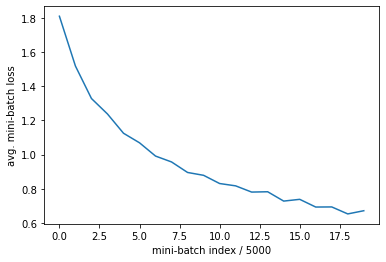

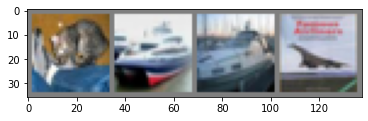

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship  ship plane
Accuracy of the network on the 10000 test images: 72 %
Accuracy of plane : 80 %
Accuracy of   car : 91 %
Accuracy of  bird : 60 %
Accuracy of   cat : 53 %
Accuracy of  deer : 67 %
Accuracy of   dog : 63 %
Accuracy of  frog : 78 %
Accuracy of horse : 75 %
Accuracy of  ship : 85 %
Accuracy of truck : 68 %


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #block one
        self.c_1 = Conv2d(3, 10, 3, stride=1, padding=1)
        self.r_1 = ReLU()
        self.avg_1 = AvgPool2d(2)

        #block two
        self.c_2 = Conv2d(10, 20, 3, stride=1, padding=1)

        #Block three
        self.c_3 = Conv2d(20, 40, 3, stride=1, padding=1)
        self.r_2 = LeakyReLU(negative_slope=0.15)
        
        #Block four
        self.c_4 = Conv2d(40, 60, 3, stride=1, padding=1)
        
        
        self.l_1 = nn.Linear(240, 100)
        self.l_2 = nn.Linear(100, 10)

    def forward(self, x):

        x = self.avg_1(self.r_1(self.c_1(x)))
        x = self.avg_1(self.r_1(self.c_2(x)))
        x = self.avg_1(self.r_2(self.c_3(x)))        
        x = self.avg_1(self.r_2(self.c_4(x)))
        x = x.view(-1, 240)

        x = self.r_2(self.l_1(x))
        x = self.l_2(x)

        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

# SGD
opt = optim.Adamax(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Training procedure
st = time.time()
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 5000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')
et = time.time()
print((et-st)/60)

plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()


# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

### Best CNN

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=120, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=120, out_channels=240, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=240, out_channels=480, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(480*4*4, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 10)
        self.bn1 = nn.BatchNorm2d(120)
        self.bn2 = nn.BatchNorm2d(240)
        self.bn3 = nn.BatchNorm2d(480)

    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 480*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net() # Create the network instance.
net.to(device)

Net(
  (conv1): Conv2d(3, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(120, 240, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(240, 480, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=7680, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (bn1): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

[epoch: 0, i:  4999] avg mini-batch loss: 1.389
[epoch: 1, i:  4999] avg mini-batch loss: 0.887
[epoch: 2, i:  4999] avg mini-batch loss: 0.695
[epoch: 3, i:  4999] avg mini-batch loss: 0.569
[epoch: 4, i:  4999] avg mini-batch loss: 0.460
[epoch: 5, i:  4999] avg mini-batch loss: 0.377
[epoch: 6, i:  4999] avg mini-batch loss: 0.286
[epoch: 7, i:  4999] avg mini-batch loss: 0.222
[epoch: 8, i:  4999] avg mini-batch loss: 0.160
[epoch: 9, i:  4999] avg mini-batch loss: 0.117
[epoch: 10, i:  4999] avg mini-batch loss: 0.087
[epoch: 11, i:  4999] avg mini-batch loss: 0.071
[epoch: 12, i:  4999] avg mini-batch loss: 0.054
[epoch: 13, i:  4999] avg mini-batch loss: 0.046
[epoch: 14, i:  4999] avg mini-batch loss: 0.038
[epoch: 15, i:  4999] avg mini-batch loss: 0.036
[epoch: 16, i:  4999] avg mini-batch loss: 0.029
[epoch: 17, i:  4999] avg mini-batch loss: 0.026
[epoch: 18, i:  4999] avg mini-batch loss: 0.025
[epoch: 19, i:  4999] avg mini-batch loss: 0.023
Finished Training.
Training ti

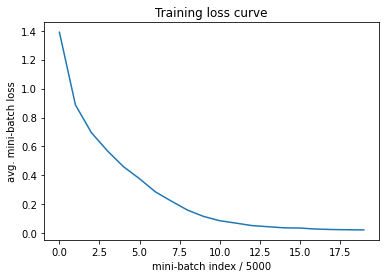

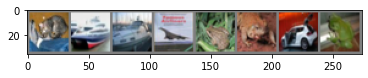

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efa69034a60>
Traceback (most recent call last):
  File "/home/zic017/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/zic017/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efa69034a60>
Traceback (most recent call last):
  File "/home/zic017/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/zic017/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
 



Accuracy of the network on the 10000 test images: 81 %


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efa69034a60>
Traceback (most recent call last):
  File "/home/zic017/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/zic017/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efa69034a60>
Traceback (most recent call last):
  File "/home/zic017/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/zic017/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
 

Accuracy of plane : 85 %
Accuracy of   car : 93 %
Accuracy of  bird : 69 %
Accuracy of   cat : 69 %
Accuracy of  deer : 81 %
Accuracy of   dog : 72 %
Accuracy of  frog : 92 %
Accuracy of horse : 84 %
Accuracy of  ship : 88 %
Accuracy of truck : 82 %


In [41]:
train_test(net)

### Second Best CNN
#### changing optimizer
Adamax

#### adding layers
3 layers

#### changing the number of channels produced by convolutional layers
1st convolutional layer: out_channels=100 <br>
2nd convolutional layer: out_channels=200 <br>
3rd convolutional layer: out_channels=400


#### added normalization
3 batch normalizations

#### changing input & output channels of linear layer 

In [102]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=100, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(100)
        self.conv2 = nn.Conv2d(in_channels=100, out_channels=200, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(200)
        self.conv3 = nn.Conv2d(in_channels=200, out_channels=400, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(400)
        
        self.lin1 = nn.Linear(400*4*4, 400)
        self.lin2 = nn.Linear(400, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

net = Net() # Create the network instance.
net.to(device)

Net(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(200, 400, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=6400, out_features=400, bias=True)
  (lin2): Linear(in_features=400, out_features=10, bias=True)
)

[epoch: 0, i:  4999] avg mini-batch loss: 1.555
[epoch: 0, i:  9999] avg mini-batch loss: 1.142
[epoch: 1, i:  4999] avg mini-batch loss: 0.902
[epoch: 1, i:  9999] avg mini-batch loss: 0.839
[epoch: 2, i:  4999] avg mini-batch loss: 0.709
[epoch: 2, i:  9999] avg mini-batch loss: 0.686
[epoch: 3, i:  4999] avg mini-batch loss: 0.570
[epoch: 3, i:  9999] avg mini-batch loss: 0.584
[epoch: 4, i:  4999] avg mini-batch loss: 0.488
[epoch: 4, i:  9999] avg mini-batch loss: 0.481
[epoch: 5, i:  4999] avg mini-batch loss: 0.405
[epoch: 5, i:  9999] avg mini-batch loss: 0.412
[epoch: 6, i:  4999] avg mini-batch loss: 0.322
[epoch: 6, i:  9999] avg mini-batch loss: 0.331
[epoch: 7, i:  4999] avg mini-batch loss: 0.261
[epoch: 7, i:  9999] avg mini-batch loss: 0.273
[epoch: 8, i:  4999] avg mini-batch loss: 0.197
[epoch: 8, i:  9999] avg mini-batch loss: 0.222
[epoch: 9, i:  4999] avg mini-batch loss: 0.154
[epoch: 9, i:  9999] avg mini-batch loss: 0.179
Finished Training.
Training time: 15.766

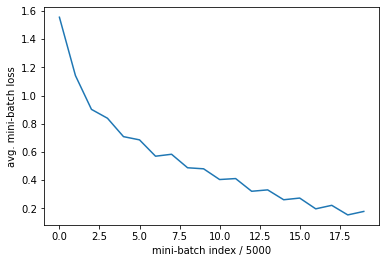

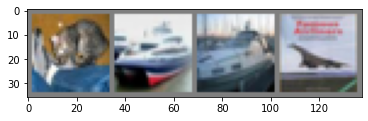

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 80 %
Accuracy of plane : 86 %
Accuracy of   car : 93 %
Accuracy of  bird : 68 %
Accuracy of   cat : 59 %
Accuracy of  deer : 78 %
Accuracy of   dog : 77 %
Accuracy of  frog : 88 %
Accuracy of horse : 80 %
Accuracy of  ship : 87 %
Accuracy of truck : 82 %


In [103]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()

# Adamax optimizer
opt = optim.Adamax(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Training procedure
st = time.time()
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 5000  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)

        # Backward step.
        loss.backward()

        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')
et = time.time()
print('Training time:', (et-st)/60, 'min')

plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()


# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

## ResNet

In [45]:
class Basic(nn.Module):
    expansion = 1
    
    def __init__(self, in_chan, out_chan, stride=1):
        super(Basic, self).__init__()

        self.conv1 = nn.Conv2d(in_chan, out_chan, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.conv2 = nn.Conv2d(out_chan, out_chan, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_chan)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_chan != self.expansion*in_chan:
            self.shortcut = nn.Sequential(nn.Conv2d(in_chan, self.expansion*out_chan, 1, stride, bias=False),
                                         nn.BatchNorm2d(self.expansion*out_chan))
            
    def forward(self, x):
        
        result = F.relu(self.bn1(self.conv1(x)))
        result = self.bn2(self.conv2(result))
        result += self.shortcut(x)
        result = F.relu(result)
        
        return result

    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_chan = 100

        self.conv1 = nn.Conv2d(3, 100, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(100)
        self.layer1 = self.create_layer(block, 100, num_blocks[0], stride=1)
        self.layer2 = self.create_layer(block, 200, num_blocks[1], stride=2)
        self.linear = nn.Linear(200*block.expansion, num_classes)

    def create_layer(self, block, out_chan, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_chan, out_chan, stride))
            self.in_chan = out_chan * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = F.avg_pool2d(x, 16)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
    
net = ResNet(Basic, [3, 4, 6, 3])     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

ResNet(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Basic(
      (conv1): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): Basic(
      (conv1): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, aff

[epoch: 0, i:  4999] avg mini-batch loss: 1.561
[epoch: 1, i:  4999] avg mini-batch loss: 0.999
[epoch: 2, i:  4999] avg mini-batch loss: 0.753
[epoch: 3, i:  4999] avg mini-batch loss: 0.613
[epoch: 4, i:  4999] avg mini-batch loss: 0.507
[epoch: 5, i:  4999] avg mini-batch loss: 0.429
[epoch: 6, i:  4999] avg mini-batch loss: 0.356
[epoch: 7, i:  4999] avg mini-batch loss: 0.300
[epoch: 8, i:  4999] avg mini-batch loss: 0.246
[epoch: 9, i:  4999] avg mini-batch loss: 0.201
[epoch: 10, i:  4999] avg mini-batch loss: 0.166
[epoch: 11, i:  4999] avg mini-batch loss: 0.133
[epoch: 12, i:  4999] avg mini-batch loss: 0.105
[epoch: 13, i:  4999] avg mini-batch loss: 0.085
[epoch: 14, i:  4999] avg mini-batch loss: 0.071
[epoch: 15, i:  4999] avg mini-batch loss: 0.062
[epoch: 16, i:  4999] avg mini-batch loss: 0.051
[epoch: 17, i:  4999] avg mini-batch loss: 0.044
[epoch: 18, i:  4999] avg mini-batch loss: 0.039
[epoch: 19, i:  4999] avg mini-batch loss: 0.034
Finished Training.
Training ti

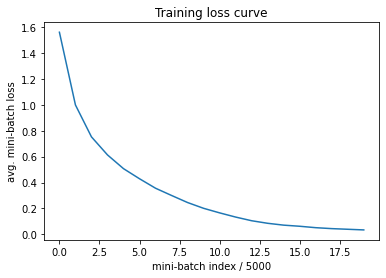

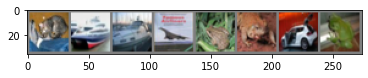

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


Accuracy of the network on the 10000 test images: 86 %
Accuracy of plane : 86 %
Accuracy of   car : 95 %
Accuracy of  bird : 75 %
Accuracy of   cat : 71 %
Accuracy of  deer : 85 %
Accuracy of   dog : 86 %
Accuracy of  frog : 92 %
Accuracy of horse : 88 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %


In [46]:
train_test(net)